# Chapter 8: Winningest Methods in Time Series Forecasting

Compiled by: Sebastian C. Ibañez

In previous sections, we examined several models used in time series forecasting such as ARIMA, VAR, and Exponential Smoothing methods. While the main advantage of traditional statistical methods is their ability to perform more sophisticated inference tasks directly (e.g. hypothesis testing on parameters, causality testing), they usually lack predictive power because of their rigid assumptions. That is not to say that they are <i>necessarily</i> inferior when it comes to forecasting, but rather they are typically used as performance benchmarks.

In this section, we demonstrate several of the fundamental ideas and approaches used in the recently concluded [`M5 Competition`](https://mofc.unic.ac.cy/m5-competition/) where challengers from all over the world competed in building time series forecasting models for both [`accuracy`](https://www.kaggle.com/c/m5-forecasting-accuracy) and [`uncertainty`](https://www.kaggle.com/c/m5-forecasting-uncertainty) prediction tasks. Specifically, we explore the machine learning model that majority of the competition's winners utilized: [`LightGBM`](https://lightgbm.readthedocs.io/en/latest/index.html), a tree-based gradient boosting framework designed for speed and efficiency.

## 1. M5 Dataset

You can download the M5 dataset from the Kaggle links above. 

Let's load the dataset and examine it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plot_x_size = 15
plot_y_size = 2

np.set_printoptions(precision = 6, suppress = True)

date_list = [d.strftime('%Y-%m-%d') for d in pd.date_range(start = '2011-01-29', end = '2016-04-24')]

df_calendar = pd.read_csv('../data/m5/calendar.csv')
df_price = pd.read_csv('../data/m5/sell_prices.csv')
df_sales = pd.read_csv('../data/m5/sales_train_validation.csv')

In [2]:
df_sales.rename(columns = dict(zip(df_sales.columns[6:], date_list)), inplace = True)
df_sales

,id,item_id,dept_id,cat_id,store_id,state_id,2011-01-29,2011-01-30,2011-01-31,2011-02-01,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [3]:
df_calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [4]:
df_price

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


#### Sample Product

Let's choose a random product and plot it.

In [5]:
df_sample = df_sales.iloc[3, :]
series_sample = df_sample.iloc[6:]

df_sample

id            HOBBIES_1_004_CA_1_validation
item_id                       HOBBIES_1_004
dept_id                           HOBBIES_1
cat_id                              HOBBIES
store_id                               CA_1
                          ...              
2016-04-20                                0
2016-04-21                                1
2016-04-22                                3
2016-04-23                                7
2016-04-24                                2
Name: 3, Length: 1919, dtype: object

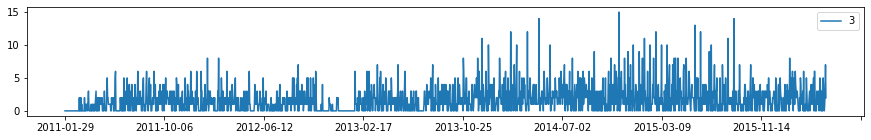

In [6]:
plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

series_sample.plot()
plt.legend()
plt.show()

#### Pick a Time Series

Let's try and find an interesting time series to forecast.

In [7]:
df_sales_total_by_store = df_sales.groupby(['store_id']).sum()
df_sales_total_by_store

,2011-01-29,2011-01-30,2011-01-31,2011-02-01,2011-02-02,2011-02-03,2011-02-04,2011-02-05,2011-02-06,2011-02-07,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
store_id,,,,,,,,,,,,,,,,,,,,,
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,...,3982,5437,5954,4345,3793,3722,3709,4387,5577,6113
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,...,4440,5352,5760,3830,3631,3691,3303,4457,5884,6082
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,...,5337,6936,8271,6068,5683,5235,5018,5623,7419,7721
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,...,2496,2839,3047,2809,2677,2500,2458,2628,2954,3271
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,...,3084,3724,4192,3410,3257,2901,2776,3022,3700,4033
TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,2932,...,3897,4475,4998,3311,3727,3384,3446,3902,4483,4292
TX_3,3030,3006,2225,2169,1726,2833,1947,2848,2832,2213,...,3819,4261,4519,3147,3938,3315,3380,3691,4083,3957
WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,1355,...,3862,4862,4812,3236,3069,3242,3324,3991,4772,4874
WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,1836,...,6259,5579,5566,4347,4464,4194,4393,4988,5404,5127


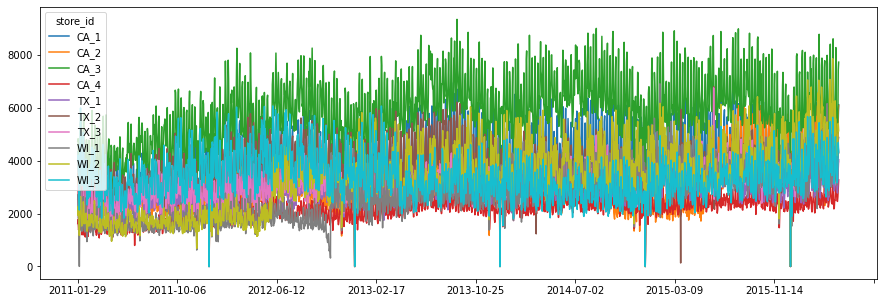

In [8]:
plt.rcParams['figure.figsize'] = [plot_x_size, 4]

df_sales_total_by_store.T.plot()
plt.show()

CA_1
Min Dates:['2011-12-25', '2012-12-25', '2013-12-25', '2014-12-25', '2015-12-25']


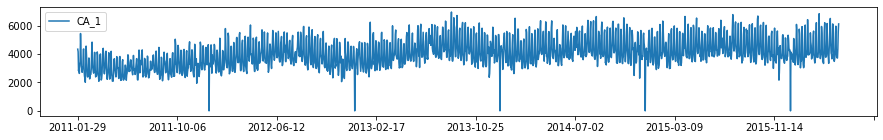

In [9]:
series = df_sales_total_by_store.iloc[0]
print(series.name)
print('Min Dates:' + str(series[series == series.min()].index.to_list()))

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

series.plot()
plt.legend()
plt.show()

## 2. Pre-processing

Before we build a forecasting model, let's check some properties of our time series.

### Is the series non-stationary?

Let's check.

In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(series)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.035408
p-value: 0.271267
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


### Does differencing make the series stationary?

Let's check.

In [11]:
def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
 
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

series_d1 = difference(series)
result = adfuller(series_d1)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -20.626012
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


### Is the series seasonal?

Let's check.

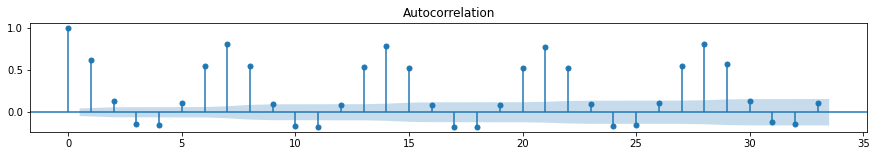

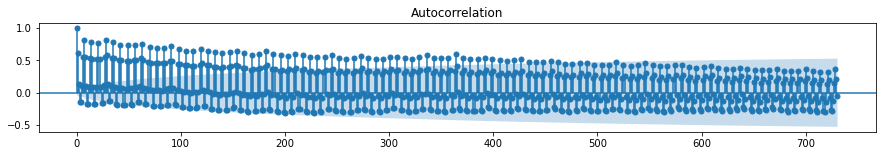

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

plot_acf(series)
plt.show()

plot_acf(series, lags = 730, use_vlines = True)
plt.show()

### Can we remove the seasonality?

Let's check.

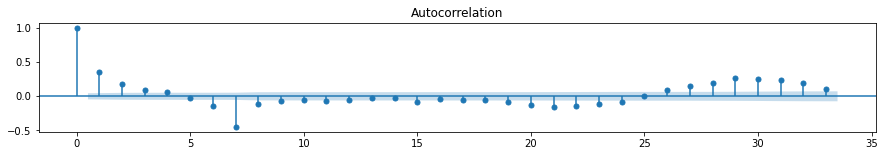

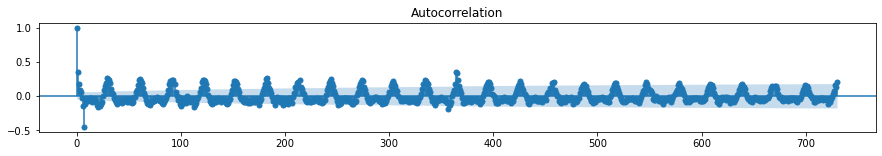

In [13]:
series_d7 = difference(series, 7)

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

plot_acf(series_d7)
plt.show()

plot_acf(series_d7, lags = 730, use_vlines = True)
plt.show()

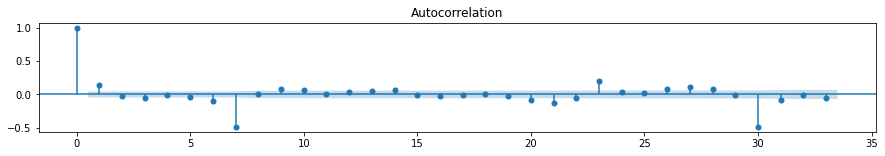

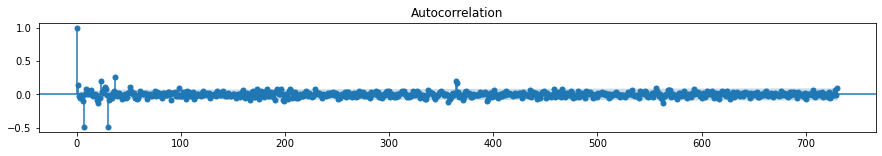

In [14]:
series_d7_d30 = difference(series_d7, 30)

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

plot_acf(series_d7_d30)
plt.show()

plot_acf(series_d7_d30, lags = 730, use_vlines = True)
plt.show()

In [15]:
result = adfuller(series_d7_d30)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.405429
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


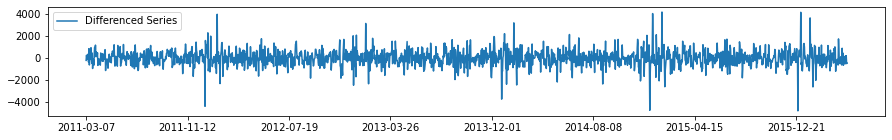

In [16]:
series_d7_d30 = pd.Series(series_d7_d30)
series_d7_d30.index = date_list[37:]

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

series_d7_d30.plot(label = 'Differenced Series')
plt.legend()
plt.show()

### What now?

At this point we have two options:

- Model the seasonally differenced series, then reverse the differencing after making predictions.

- Model the original series directly.

While (vanilla) ARIMA requires a non-stationary and non-seasonal time series, these properties are not necessary for most non-parametric ML models.

## 3. One-Step Prediction

Let's build a model for making one-step forecasts.

To do this, we first need to transform the time series data into a supervised learning dataset.

In other words, we need to create a new dataset consisting of $X$ and $Y$ variables, where $X$ refers to the features and $Y$ refers to the target.

### How far do we lookback?

To create the new $(X,Y)$ dataset, we first need to decide what the $X$ features are. 

For the moment, let's ignore any exogenous variables. In this case, what determines the $X$s is how far we <i>lookback</i>. In general, we can treat the lookback as a hyperparameter, which we will call `window_size`.

<i>Advanced note:</i> Technically, we could build an entire methodology for feature engineering $X$.

### Test Set

To test our model we will use the last 28 days of the series.

In [17]:
### CREATE X,Y ####
def create_xy(series, window_size, prediction_horizon, shuffle = False):
    x = []
    y = []
    for i in range(0, len(series)):
        if len(series[(i + window_size):(i + window_size + prediction_horizon)]) < prediction_horizon:
            break
        x.append(series[i:(i + window_size)])
        y.append(series[(i + window_size):(i + window_size + prediction_horizon)])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [18]:
### HYPERPARAMETERS ###
window_size = 365
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
test_size = 28
split_time = len(series) - test_size

train_series = series[:split_time]
test_series = series[split_time - window_size:]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1520, 365)
(1520,)
(28, 365)
(28,)


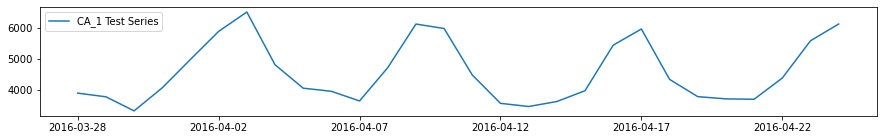

In [19]:
plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

series[-test_size:].plot(label = 'CA_1 Test Series')
plt.legend()
plt.show()

###  LightGBM

Now we can build a LightGBM model to forecast our time series.

Gradient boosting is an ensemble method that combines multiple weak models to produce a single strong prediction model. The method involves constructing the model (called a <i>gradient boosting machine</i>) in a serial stage-wise manner by sequentially optimizing a differentiable loss function at each stage. Much like other boosting algorithms, the residual errors are passed to the next weak learner and trained.

For this work, we use LightGBM, a gradient boosting framework designed for speed and efficiency. Specifically, the framework uses tree-based learning algorithms.

To tune the model's hyperparameters, we use a combination of grid search and repeated k-fold cross validation, with some manual tuning. For more details, see the Hyperparameter Tuning notebook.

Now we train the model on the full dataset and test it.

In [20]:
import lightgbm as lgb

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, max_depth=4,
              n_estimators=2000, num_leaves=16)

     Naive MAE: 698.0000
  s7-Naive MAE: 372.2857
 s30-Naive MAE: 330.8214
s365-Naive MAE: 247.9286
  LightGBM MAE: 200.5037


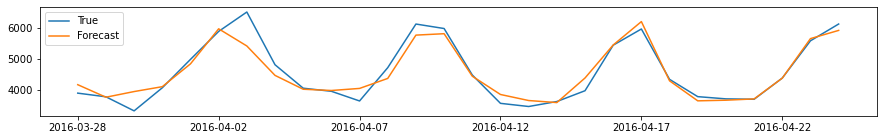

In [21]:
forecast = model.predict(test_x)
s1_naive = series[-29:-1].to_numpy()
s7_naive = series[-35:-7].to_numpy()
s30_naive = series[-56:-28].to_numpy()
s365_naive = series[-364:-336].to_numpy()

print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

series[-test_size:].plot(label = 'True')
plt.plot(forecast, label = 'Forecast')
plt.legend()
plt.show()

### Tuning Window Size
How does our metric change as we extend the window size?

  7 --- MAE: -333.105 (21.291)
 30 --- MAE: -307.008 (21.648)
180 --- MAE: -291.474 (22.537)
365 --- MAE: -275.644 (17.895)
545 --- MAE: -277.332 (20.982)
730 --- MAE: -275.664 (23.006)


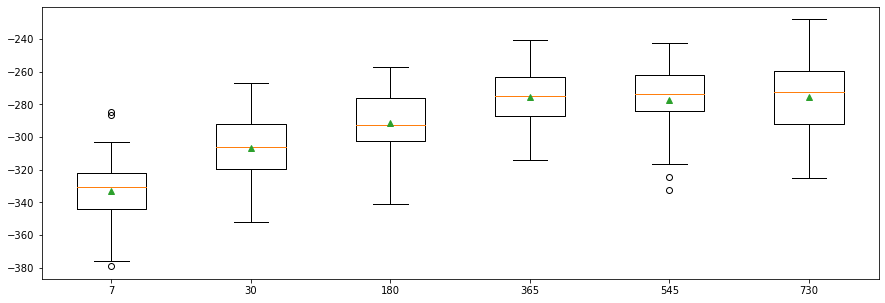

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

windows = [7, 30, 180, 365, 545, 730]

results = []
names = []
for w in windows:

    window_size = w

    train_x, train_y = create_xy(train_series, window_size, prediction_horizon)

    train_y = train_y.flatten()

    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 123)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(w)
    print('%3d --- MAE: %.3f (%.3f)' % (w, np.mean(scores), np.std(scores)))

plt.rcParams['figure.figsize'] = [plot_x_size, 5]    
    
plt.boxplot(results, labels = names, showmeans = True)
plt.show()

## 4. Multi-Step Prediction

Suppose we were interested in forecasting the next $n$-days instead of just the next day.

There are several approaches we can take to solve this problem.

In [23]:
### HYPERPARAMETERS ###
window_size = 365
prediction_horizon = 1

### TRAIN VAL SPLIT ###
test_size = 28
split_time = len(series) - test_size

train_series = series[:split_time]
test_series = series[split_time - window_size:]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

### Recursive Forecasting

In recursive forecasting, we first train a one-step model then generate a multi-step forecast by recursively feeding our predictions back into the model.

In [24]:
params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, max_depth=4,
              n_estimators=2000, num_leaves=16)

  One-Step MAE: 200.5037
Multi-Step MAE: 214.8020


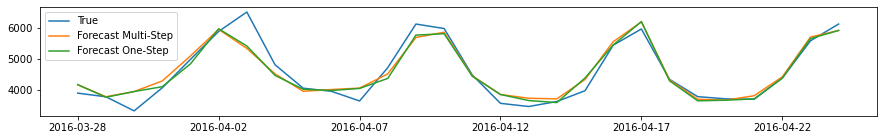

In [25]:
recursive_x = test_x[0, :]

forecast_ms = []
for i in range(test_x.shape[0]):
    pred = model.predict(recursive_x.reshape((1, recursive_x.shape[0])))
    recursive_x = np.append(recursive_x[1:], pred)
    forecast_ms.append(pred)
    
forecast_ms_rec = np.asarray(forecast_ms).flatten()
forecast_os = model.predict(test_x)

print('  One-Step MAE: %.4f' % (np.mean(np.abs(forecast_os - test_y))))
print('Multi-Step MAE: %.4f' % (np.mean(np.abs(forecast_ms_rec - test_y))))

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

series[-test_size:].plot(label = 'True')
plt.plot(forecast_ms_rec, label = 'Forecast Multi-Step')
plt.plot(forecast_os, label = 'Forecast One-Step')
plt.legend()
plt.show()

### Direct Forecasting

In direct forecasting, we train $n$ independent models and generate a multi-step forecast by concatenating the $n$ predictions.

For this implementation, we need to create a new $(X,Y)$ dataset, where $Y$ is now a vector of $n$ values.

In [26]:
### HYPERPARAMETERS ###
window_size = 365
prediction_horizon = 28

### TRAIN VAL SPLIT ###
test_size = 28
split_time = len(series) - test_size

train_series = series[:split_time]
test_series = series[split_time - window_size:]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

In [27]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(lgb.LGBMRegressor(), n_jobs = -1)

model.fit(train_x, train_y)

MultiOutputRegressor(estimator=LGBMRegressor(), n_jobs=-1)

  One-Step MAE: 200.5037
Multi-Step MAE: 233.6326


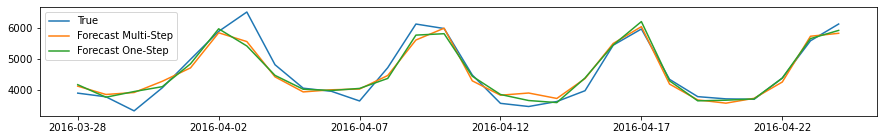

In [28]:
forecast_ms_dir = model.predict(test_x)

print('  One-Step MAE: %.4f' % (np.mean(np.abs(forecast_os - test_y))))
print('Multi-Step MAE: %.4f' % (np.mean(np.abs(forecast_ms_dir - test_y))))

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

series[-test_size:].plot(label = 'True')
plt.plot(forecast_ms_dir.T, label = 'Forecast Multi-Step')
plt.plot(forecast_os, label = 'Forecast One-Step')
plt.legend()
plt.show()

### Single-Shot Forecasting

In single-shot forecasting, we create a model that attempts to predict all $n$-steps simultaneously.

Unfortunately, LightGBM (tree-based methods in general) does not support multi-output models.

### Forecast Combination

An easy way to improve forecast accuracy is to use several different methods on the same time series, and to average the resulting forecasts.

  Recursive MAE: 214.8020
     Direct MAE: 233.6326
Combination MAE: 217.0313


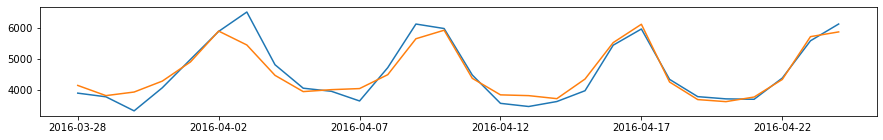

In [29]:
forecast_ms_comb = 0.5*forecast_ms_dir.flatten() + 0.5*forecast_ms_rec

print('  Recursive MAE: %.4f' % (np.mean(np.abs(forecast_ms_rec - test_y))))
print('     Direct MAE: %.4f' % (np.mean(np.abs(forecast_ms_dir - test_y))))
print('Combination MAE: %.4f' % (np.mean(np.abs(forecast_ms_comb - test_y))))

series[-test_size:].plot(label = 'True')
plt.plot(forecast_ms_comb, label = 'Forecast Combination')
plt.show()

## 5. Feature Importance

One advantage of GBM models is that it can generate feature importance metrics based on the quality of the splits (or information gain).

In [30]:
### HYPERPARAMETERS ###
window_size = 365
prediction_horizon = 1

### TRAIN VAL SPLIT ###
test_size = 28
split_time = len(series) - test_size

train_series = series[:split_time]
test_series = series[split_time - window_size:]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()
    
params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

feature_name_list = ['lag_' + str(i+1) for i in range(window_size)]

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          feature_name = feature_name_list,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, max_depth=4,
              n_estimators=2000, num_leaves=16)

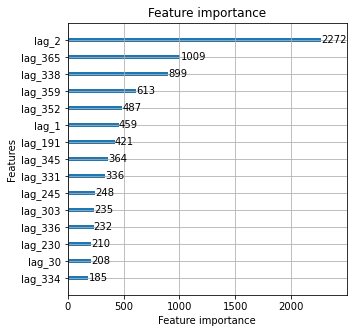

In [31]:
plt.rcParams['figure.figsize'] = [5, 5]

lgb.plot_importance(model, max_num_features = 15, importance_type = 'split')
plt.show()

## Summary

In summary, this section has shown the following:

- A quick exploration of the M5 dataset and its salient features
- Checking the usual assumptions for classical time series analysis
- Demonstrating the 'out-of-the-box' performance of LightGBM models
- Demonstrating how tuning the lookback window can effect forecasting performance
- Demonstrating how tuning the hyperparameters of a LightGBM model can improve performance
- Summarizing the different approaches to multi-step forecasting
- Illustrating that gradient boosting methods can measure feature importance

Many of the methods and approaches shown above are easily extendable. Of note, because of the non-parametric nature of most machine learning models, performing classical inference tasks like hypothesis testing is more challenging. However, trends in ML research have been moving towards greater interpretability of so-called 'black box' models, such as SHAP for feature importance and even Bayesian approaches to neural networks for causality inference.

## References

[1] S. Makridakis, E. Spiliotis, and V. Assimakopoulos. The M5 Accuracy competition: Results, findings and conlusions. 2020.

[2] S. Makridakis, E. Spiliotis, V. Assimakopoulos, Z. Chen, A. Gaba, I. Tsetlin, and R. Winkler. The M5 Uncertainty competition: Results, findings and conlusions. 2020.

[3] V. Jose, and R. Winkler. Evaluating quantile assessments. Operations research, 2009.

[4] A. Gaba, I. Tsetlin, and R. Winkler. Combining interval forecasts. Decision Analysis, 2017.